C:\Users\rajva\AppData\Local\Temp\ipykernel_4636\1108565673.py:182: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  canvas.draw()
c:\Users\rajva\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py:862: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  func(*args)
C:\Users\rajva\AppData\Local\Temp\ipykernel_4636\1108565673.py:182: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  canvas.draw()
c:\Users\rajva\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py:862: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  func(*args)
C:\Users\rajva\AppData\Local\Temp\ipykernel_4636\1108565673.py:182: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  canvas.draw()
c:\Users\rajva\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py:862: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  func(*args

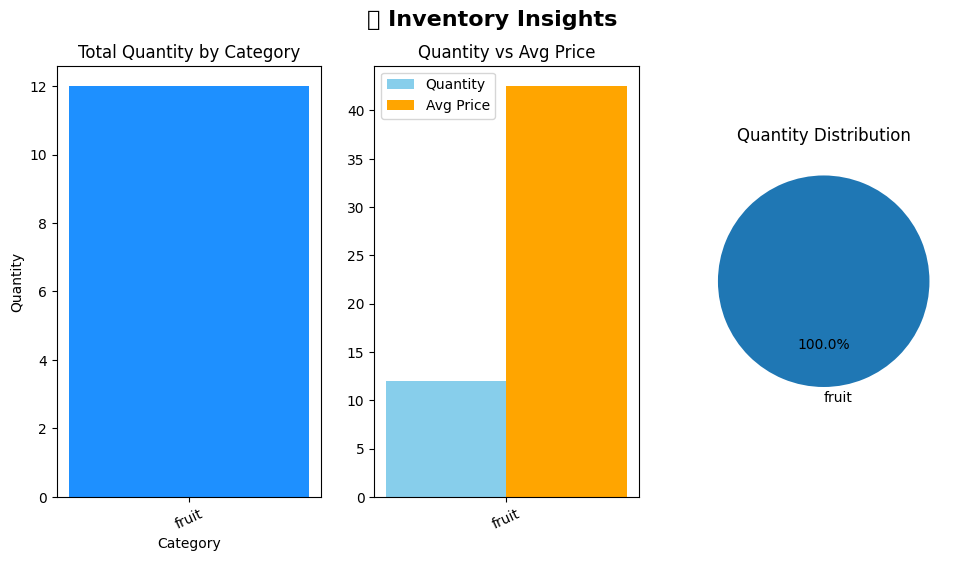

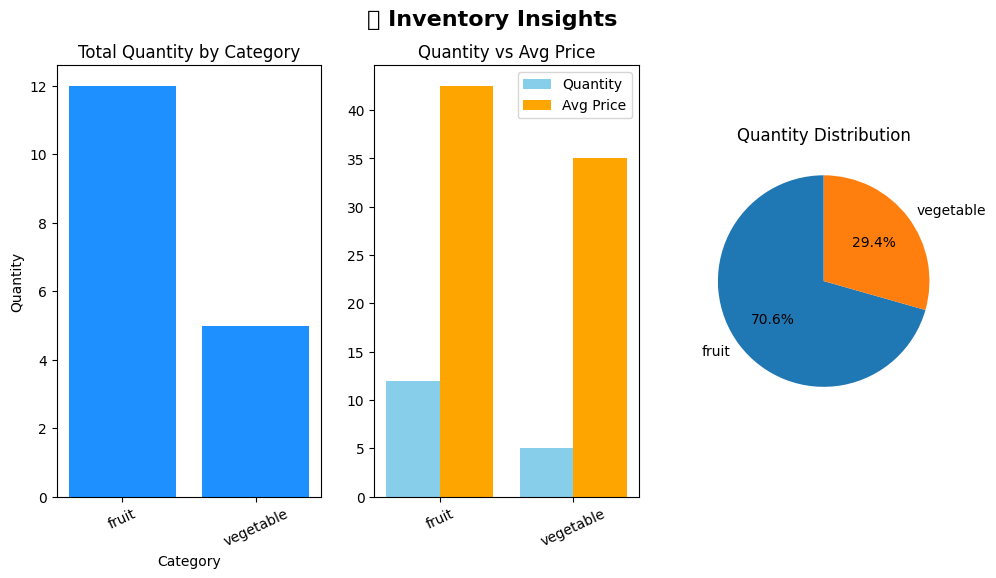

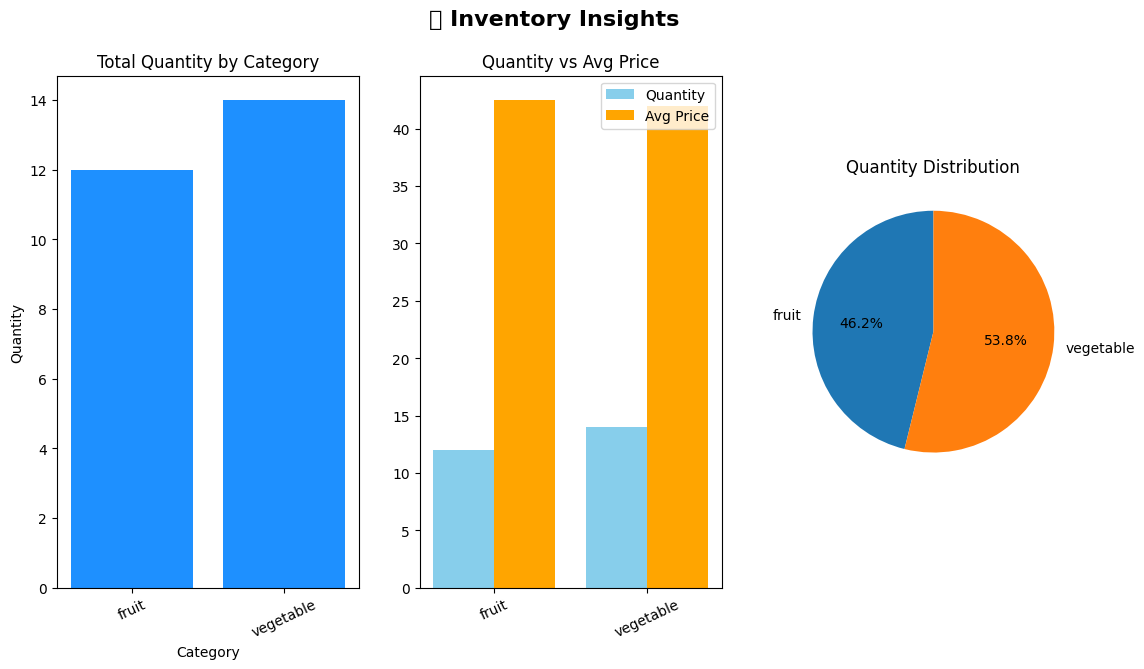

In [10]:
import tkinter as tk
from tkinter import ttk, messagebox
import sqlite3
from tkcalendar import DateEntry
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


# ---------------- Database Setup ----------------
def init_db():
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS items (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        name TEXT NOT NULL,
                        category TEXT,
                        quantity INTEGER,
                        price REAL,
                        supplier TEXT,
                        date TEXT)''')

    # Add column 'date' if missing
    try:
        cursor.execute("ALTER TABLE items ADD COLUMN date TEXT")
    except sqlite3.OperationalError:
        pass

    conn.commit()
    conn.close()


# ---------------- CRUD Functions ----------------
def add_item():
    name = name_var.get()
    category = category_var.get()
    quantity = quantity_var.get()
    price = price_var.get()
    supplier = supplier_var.get()
    date = date_entry.get_date().strftime("%Y-%m-%d")

    if not name or not quantity or not price:
        messagebox.showwarning("Input Error", "Name, Quantity, and Price are required!")
        return

    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO items (name, category, quantity, price, supplier, date) VALUES (?, ?, ?, ?, ?, ?)",
                   (name, category, quantity, price, supplier, date))
    conn.commit()
    conn.close()
    clear_fields()
    view_items()


def view_items():
    for row in tree.get_children():
        tree.delete(row)

    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM items")
    rows = cursor.fetchall()
    conn.close()

    for row in rows:
        tree.insert("", tk.END, values=row)


def delete_item():
    selected = tree.selection()
    if not selected:
        messagebox.showwarning("Selection Error", "Please select an item to delete!")
        return

    item_id = tree.item(selected[0])['values'][0]

    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute("DELETE FROM items WHERE id=?", (item_id,))
    conn.commit()
    conn.close()
    view_items()


def update_item():
    selected = tree.selection()
    if not selected:
        messagebox.showwarning("Selection Error", "Please select an item to update!")
        return

    item_id = tree.item(selected[0])['values'][0]
    date = date_entry.get_date().strftime("%Y-%m-%d")

    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute("""
        UPDATE items
        SET name=?, category=?, quantity=?, price=?, supplier=?, date=?
        WHERE id=?
    """, (name_var.get(), category_var.get(), quantity_var.get(), price_var.get(),
          supplier_var.get(), date, item_id))
    conn.commit()
    conn.close()
    view_items()
    clear_fields()


def search_item():
    keyword = search_var.get()
    for row in tree.get_children():
        tree.delete(row)

    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM items WHERE name LIKE ? OR category LIKE ?", 
                   ('%' + keyword + '%', '%' + keyword + '%'))
    rows = cursor.fetchall()
    conn.close()

    for row in rows:
        tree.insert("", tk.END, values=row)


def clear_fields():
    name_var.set("")
    category_var.set("")
    quantity_var.set(0)
    price_var.set(0.0)
    supplier_var.set("")
    date_entry.set_date(datetime.now())
    search_var.set("")


# ---------------- Visualization with Subplots ----------------
def open_visual_window():
    visual_win = tk.Toplevel(root)
    visual_win.title("📊 Inventory Visualization Dashboard")
    visual_win.geometry("1200x600")
    visual_win.configure(bg="#f0f0f0")

    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()
    cursor.execute("SELECT category, SUM(quantity), AVG(price) FROM items GROUP BY category")
    data = cursor.fetchall()
    conn.close()

    if not data:
        tk.Label(visual_win, text="No data available for visualization.", bg="#f0f0f0", font=("Arial", 12)).pack(pady=20)
        return

    categories = [d[0] if d[0] else "Uncategorized" for d in data]
    quantities = [d[1] for d in data]
    avg_prices = [d[2] for d in data]

    # ----- Create one figure with subplots -----
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle("📊 Inventory Insights", fontsize=16, fontweight="bold")

    # --- Subplot 1: Bar Chart ---
    axes[0].bar(categories, quantities, color="dodgerblue")
    axes[0].set_title("Total Quantity by Category")
    axes[0].set_xlabel("Category")
    axes[0].set_ylabel("Quantity")
    axes[0].tick_params(axis='x', rotation=25)

    # --- Subplot 2: Clustered Bar (Quantity vs Avg Price) ---
    x = range(len(categories))
    axes[1].bar([i - 0.2 for i in x], quantities, width=0.4, label="Quantity", color="skyblue")
    axes[1].bar([i + 0.2 for i in x], avg_prices, width=0.4, label="Avg Price", color="orange")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(categories, rotation=25)
    axes[1].set_title("Quantity vs Avg Price")
    axes[1].legend()

    # --- Subplot 3: Pie Chart ---
    axes[2].pie(quantities, labels=categories, autopct="%1.1f%%", startangle=90)
    axes[2].set_title("Quantity Distribution")

    # Add figure to Tkinter
    canvas = FigureCanvasTkAgg(fig, master=visual_win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill="both", expand=True, padx=20, pady=20)


# ---------------- GUI Setup ----------------
root = tk.Tk()
root.title("📦 Inventory Management System")
root.geometry("1100x700")
root.configure(bg="#f0f0f0")

init_db()

# Variables
name_var = tk.StringVar()
category_var = tk.StringVar()
quantity_var = tk.IntVar()
price_var = tk.DoubleVar()
supplier_var = tk.StringVar()
search_var = tk.StringVar()

# ---------- Input Form ----------
form_frame = tk.LabelFrame(root, text="Add / Edit Item", padx=10, pady=10, bg="#f0f0f0")
form_frame.pack(fill="x", padx=20, pady=10)

tk.Label(form_frame, text="Name:", bg="#f0f0f0").grid(row=0, column=0, sticky="w")
tk.Entry(form_frame, textvariable=name_var, width=25).grid(row=0, column=1, padx=5)

tk.Label(form_frame, text="Category:", bg="#f0f0f0").grid(row=0, column=2, sticky="w")
tk.Entry(form_frame, textvariable=category_var, width=25).grid(row=0, column=3, padx=5)

tk.Label(form_frame, text="Quantity:", bg="#f0f0f0").grid(row=1, column=0, sticky="w")
tk.Entry(form_frame, textvariable=quantity_var, width=25).grid(row=1, column=1, padx=5)

tk.Label(form_frame, text="Price:", bg="#f0f0f0").grid(row=1, column=2, sticky="w")
tk.Entry(form_frame, textvariable=price_var, width=25).grid(row=1, column=3, padx=5)

tk.Label(form_frame, text="Supplier:", bg="#f0f0f0").grid(row=2, column=0, sticky="w")
tk.Entry(form_frame, textvariable=supplier_var, width=25).grid(row=2, column=1, padx=5)

tk.Label(form_frame, text="Date:", bg="#f0f0f0").grid(row=2, column=2, sticky="w")
date_entry = DateEntry(form_frame, width=22, background="darkblue", foreground="white", borderwidth=2)
date_entry.grid(row=2, column=3, padx=5)

tk.Button(form_frame, text="Add", command=add_item, bg="#4caf50", fg="white").grid(row=3, column=0, pady=10)
tk.Button(form_frame, text="Update", command=update_item, bg="#2196f3", fg="white").grid(row=3, column=1)
tk.Button(form_frame, text="Delete", command=delete_item, bg="#f44336", fg="white").grid(row=3, column=2)
tk.Button(form_frame, text="Clear", command=clear_fields, bg="#9e9e9e", fg="white").grid(row=3, column=3)

# ---------- Search Bar ----------
search_frame = tk.Frame(root, bg="#f0f0f0")
search_frame.pack(fill="x", padx=20, pady=5)
tk.Label(search_frame, text="Search:", bg="#f0f0f0").pack(side="left")
tk.Entry(search_frame, textvariable=search_var, width=30).pack(side="left", padx=5)
tk.Button(search_frame, text="Search", command=search_item, bg="#607d8b", fg="white").pack(side="left", padx=5)
tk.Button(search_frame, text="Show All", command=view_items, bg="#455a64", fg="white").pack(side="left", padx=5)
tk.Button(search_frame, text="Visualize Data", command=open_visual_window, bg="#673ab7", fg="white").pack(side="right", padx=5)

# ---------- Data Table ----------
table_frame = tk.Frame(root, bg="#f0f0f0")
table_frame.pack(fill="both", expand=True, padx=20, pady=10)

columns = ("ID", "Name", "Category", "Quantity", "Price", "Supplier", "Date")
tree = ttk.Treeview(table_frame, columns=columns, show="headings")
for col in columns:
    tree.heading(col, text=col)
    tree.column(col, anchor="center")

tree.pack(fill="both", expand=True)
view_items()

root.mainloop()
